# Python Assignment 4

⏱⏱⏱**Due: 11/30/2025 11:59:59 PM** ⏱⏱⏱

Please submit your notebook files and upload them to your Git repository. Don't forget to include a link to your Git repository when submitting this file on Brightspace.

Total points: 150 (equivalent to 15 points after conversion)

I have provided some guidance in comments to help you through the steps, but feel free to approach this in a different way if you prefer. **Feel free to disregard my comments if you have an alternative approach in mind.**

## 5. Image Binary Classification (30 pts)



For Question 5 of the Python project, please complete it using two distinct Jupyter Notebook scripts. This entails using one notebook for the original dataset and another for the modified dataset. Consequently, you will be submitting a total of three .ipynb files as part of your Python project, ensuring clear separation and organization of your work.

Your tasks:
1. Your first task is to re-implement the classification model that was covered in our class. Please start from scratch and write the code independently. You can refer to the original code provided on Brightspace if you encounter any difficulties, but try to write the code on your own to reinforce your understanding.

2. After implementing the classification model, **report the indices of all the images in the test set for which the model's predictions are incorrect.** To maintain consistency with Python’s convention, please begin your indexing with 0. Additionally, **display the images of 4 of these failed cases for visual examination (you can display more if you like)**. This analysis might help us identify instances where the model is struggling in some applications.

3. Now you will modify the code to treat the dataset differently. The first 160 images plus the last digit of your Student ID will constitute the new training set, while the remaining images in the original training set will be your new test set. There are 209 images in the original training set. For example, if your ID ends with 0, the first 160 images will form your training set, and the remaining 49 images will be part of your test set. The test dataset is discarded and no longer used. Re-train the model using this modified dataset and **report the training and test accuracies**. Additionally, **provide the indices of all the images in the test set for which the model's predictions are incorrect. Display 4 of these misclassified images for further examination.**

By completing these tasks, you'll gain valuable insights into the classification model's performance and its behavior under different training and testing conditions.


  Datasets: [train]: train_catvnoncat.h5, [test]: test_catvnoncat.h5

# Task 3

In [1]:
# ======================
# 1. Imports & Config
# ======================
import torch
import torch.nn as nn
import torch.optim 
from torch.utils.data import DataLoader, TensorDataset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision import transforms, models

# ======================
# 2. Device Setup
# ======================
if torch.backends.mps.is_available():
    device = torch.device("mps")   # Use Apple GPU
    print("Using device: MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")  # For other machines with NVIDIA GPUs
    print("Using device: CUDA")
else:
    device = torch.device("cpu")   # Fallback
    print("Using device: CPU")


# ======================
# 3. Data Loading & Dataset
# ======================
def load_h5_dataset():
    train_dataset = h5py.File("train_catvnoncat.h5", "r")
    #test_dataset  = h5py.File("test_catvnoncat.h5", "r") # Modified

    # typical keys in this dataset
    # Modify the number of training and test set
    num_training = 160 + 22                                  # My SBU ID ends with 22.
    train_set_x = np.array(train_dataset["train_set_x"][:num_training])  # (m_train, 64,64,3)
    train_set_y = np.array(train_dataset["train_set_y"][:num_training])  # (m_train,)
    test_set_x  = np.array(train_dataset["train_set_x"][num_training:])    # (m_test, 64,64,3)
    test_set_y  = np.array(train_dataset["train_set_y"][num_training:])    # (m_test,)

    train_dataset.close()
    #test_dataset.close()

    return train_set_x, train_set_y, test_set_x, test_set_y

# Pipeline for preprocessing of the image. 
transform = transforms.Compose([

    # Convert a tensor or an ndarray to PIL Image
    # Original array is H x W x C
    # 3 channel, default mode is RGB
    transforms.ToPILImage(),

    # Resize into a fixed size same as ImageNet dataset
    transforms.Resize((224, 224)),

    # Flip the image horizontally using the default probability 0.5
    transforms.RandomHorizontalFlip(),

    # Transform to pytorch tensor
    transforms.ToTensor(),

    # Normalizes the pixel values using mean and std of the ImageNet dataset
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# ======================
# 4. Training & Evaluation
# ======================
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)  # shape (B,1)

            optimizer.zero_grad()
            outputs = model(imgs)               # logits, shape (B,1)
            loss = criterion(outputs, labels)   # BCEWithLogitsLoss
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {epoch_loss:.4f}")

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)                   # logits
            probs = torch.sigmoid(outputs)          # [0,1]
            preds = (probs > 0.5).float().squeeze(1)  # 0/1

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return all_preds, all_labels

# ======================
# 5. Main Script
# ======================
# Load data
train_x, train_y, test_x, test_y = load_h5_dataset()
print(f"Modified training set shapes -> images: {train_x.shape}, labels: {train_y.shape}")
print(f"Modified test set shapes     -> images: {test_x.shape}, labels: {test_y.shape}")

# Apply `transform` to each image and stack into a big tensor
train_imgs = torch.stack([transform(img) for img in train_x])  # shape (N_train, C, H, W)
test_imgs  = torch.stack([transform(img) for img in test_x])   # shape (N_test, C, H, W)

# Convert labels to tensors
train_labels = torch.tensor(train_y, dtype=torch.float32)  # shape (N_train,)
test_labels  = torch.tensor(test_y,  dtype=torch.float32)  # shape (N_test,)

# Build TensorDatasets
train_dataset = TensorDataset(train_imgs, train_labels)
test_dataset  = TensorDataset(test_imgs,  test_labels)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Load pretrained model. 
# ResNet from https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Binary classification (1 output)

# Model, loss, optimizer, scheduler
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()    # Use Binary Cross Entropy With Logits Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-6)  #Set scheduler to adjust learning rate during training

# Train
num_epochs = 7
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)

# Evaluate
train_preds, train_labels_np = get_predictions(model, train_loader)
train_acc = (train_preds == train_labels_np).mean() * 100

test_preds, test_labels_np = get_predictions(model, test_loader)
test_acc = (test_preds == test_labels_np).mean() * 100

print(f"Training accuracy: {train_acc:.2f}%")
print(f"Test accuracy: {test_acc:.2f}%")

Using device: MPS (Apple GPU)
Modified training set shapes -> images: (182, 64, 64, 3), labels: (182,)
Modified test set shapes     -> images: (27, 64, 64, 3), labels: (27,)


/Users/younginkim/anaconda3/envs/youngin2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/younginkim/anaconda3/envs/youngin2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/7 - loss: 0.8196
Epoch 2/7 - loss: 0.6574
Epoch 3/7 - loss: 0.5258
Epoch 4/7 - loss: 0.4519
Epoch 5/7 - loss: 0.3724
Epoch 6/7 - loss: 0.3124
Epoch 7/7 - loss: 0.3368
Training accuracy: 97.80%
Test accuracy: 66.67%


Misclassified test indices: [ 2  3  4  5 13 21 23 25 26]
Number of misclassified images: 9


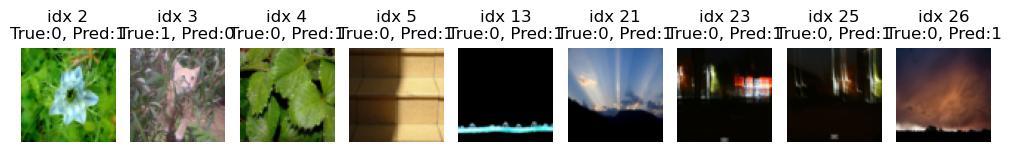

In [2]:
# Find the indices where predictions do NOT match labels
incorrect_idx = np.where(test_preds != test_labels_np)[0]
# Count how many incorrect images
num_incorrect = len(incorrect_idx)

print("Misclassified test indices:", incorrect_idx)
print("Number of misclassified images:", num_incorrect)


# Plot all incorrect prediction images
plt.figure(figsize=(10,4))

for i in range(num_incorrect):
    idx = incorrect_idx[i]
    img = test_x[idx]  # original 64x64x3 image

    true_label = int(test_labels[idx])
    pred_label = int(test_preds[idx])

    plt.subplot(1, num_incorrect, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"idx {idx}\nTrue:{true_label}, Pred:{pred_label}")

plt.tight_layout()
plt.show()